In [9]:
%matplotlib inline
import numpy as np
from IPython.core.debugger import set_trace
import time

import matplotlib.pyplot as plt
import tensorflow as tf

import h5py

# need this stuff ??
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

In [ ]:
class Data:
  def __init__(self):
    with h5py.File("cell_data.h5", "r") as data:
      # fill corresponding lists with 28 training images and 28 labels as class variables
      self.train_images = [data["/train_image_{}".format(i)][:] for i in range(28)]
      self.train_labels = [data["/train_label_{}".format(i)][:] for i in range(28)]
      self.test_images = [data["/test_image_{}".format(i)][:] for i in range(3)]
      self.test_labels = [data["/test_label_{}".format(i)][:] for i in range(3)]
    
    self.input_resolution = 300
    self.label_resolution = 116

    self.offset = (300 - 116) // 2   # returns integer 92

    image = np.empty([input_res_x, input_res_y, 1])
    label = np.empty([label_res_x, label_res_y])

  # return one randomly selected image/label out of 28 train_images and crop to resolution 300 / 116
  def get_train_image_list_and_label_list(self):
    n = random.randint(0, len(self.train_images) - 1)   # pick index out of 28
    # for selected image n crop x and y to selected resoution 300x300
    x = random.randint(0, (self.train_images[n].shape)[1] - self.input_resolution - 1)
    y = random.randint(0, (self.train_images[n].shape)[0] - self.input_resolution - 1)
    image = self.train_images[n][y:y + self.input_resolution, x:x + self.input_resolution, :]

    # for label of selected image n crop x and y accordingly to selected resoution 116 x 116
    x += self.offset
    y += self.offset
    label = self.train_labels[n][y:y + self.label_resolution, x:x + self.label_resolution]
    
    return [image], [label]

  def get_test_image_list_and_label_list(self):
    coord_list = [[0,0], [0, 300], [218, 0], [218, 300]]
    
    image_list = []
    label_list = []
    
    for image_id in range(3):
      for y, x in coord_list:
        image = self.test_images[image_id][y:y + self.input_resolution, x:x + self.input_resolution, :]
        image_list.append(image)
        x += self.offset
        y += self.offset
        label = self.test_labels[image_id][y:y + self.label_resolution, x:x + self.label_resolution]
        label_list.append(label)
    

    return image_list, label_list

# Exercise 4: Cell Segmentation u_net


In [26]:
def define_graph():

    # define input variable
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None, 10])
    
    # initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients
    # The generated values follow a normal distribution with specified mean and standard deviation, 
    # except that values whose magnitude is more than 2 standard deviations from the mean are dropped and re-picked.
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    # define small positive constant bias
    def bias_variable(shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

    # Computes a 2-D convolution given 4-D input and filter tensors. returning 4D tensor of same type as x
    # ? means zero padding überall 2, oder ?
    # X has 4D data format [batch, height, width, color channels]
    # filter w has shape [filter_height, filter_width, in_channels, out_channels]  (no of filters, first colors...?)
    # strides = The stride of the sliding window for each dimension of input Tensor, input
    # with Input Tensor = [batch, height, width, in_channels]
    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def transpose2d(x, filters, kernel_size):
        # kernel size tuple specifying spatial dimension of filter
        # filter: number of filters = number of layers in output space
        return tf.layers.conv2d_transpose(x, filters, kernel_size, strides =[2,2], padding ='SAME')

    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')

    # first convolutional layer with 8 filters, one color
    # initialise weights and bias (slightly randomized)
    # 3 x 3, 1 input (only one color), 8 output channels
    # [filter_width, filter_height, filter_depth (=no of layers input), output_filters (=no of layers output)]
    W_conv1 = weight_variable([3, 3, 1, 8])       
    b_conv1 = bias_variable([8])       

    # define tensor representing input layer: reshape flattened 748 Vector to 4d tensor 28 x 28 image matrices
    # and the final dimension corresponding to the number of color channels.
    x_image = tf.reshape(x, [-1, 28, 28, 1])

    # convolve, "same" size ("same" padding, same resolution), reduce size to 14x14 by maxpooling
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    # define second layer convolving same size, 
    W_conv2 = weight_variable([3, 3, 8, 4])  # 8 incoming filters, 4 in next layer
    b_conv2 = bias_variable([4])

    # convolve, same size (padding, stride...), reduce size to 7x7 by maxpooling
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    # define third layer convolving "same" size, 
    W_conv3 = weight_variable([3, 3, 4, 2])  # 4 incoming filters, 2 in next layer
    b_conv3 = bias_variable([2])

    # convolve, same size (padding, stride...), no further pooling, leave size 7x7
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)

    # increase size to 14x14 by transposed convolution with strides [2,2], 4 output filters
    h_transpose4 = tf.nn.relu(transpose2d(h_conv3, 4, [2,2]))
    
    # again convolving "same" size, 
    W_conv5 = weight_variable([3, 3, 4, 4])  
    b_conv5 = bias_variable([4])    
    h_conv5 = tf.nn.relu(conv2d(h_transpose4, W_conv5) + b_conv5)    
    
    # transposed, upscaling on size 28x28, 8 output filters
    h_transpose6 = tf.nn.relu(transpose2d(h_conv5, 8, [2,2]))
    
    # again convolving "same" size, filtersize 8 input and output
    W_conv7 = weight_variable([3, 3, 8, 8])  
    b_conv7 = bias_variable([8])    
    h_conv7 = tf.nn.relu(conv2d(h_transpose6, W_conv7) + b_conv7)   
    
    # output Filter, filtersize 1 x 1, 1 Output channels
    W_conv8 = weight_variable([1, 1, 8, 1])  
    b_conv8 = bias_variable([1])    
    h_conv8 = tf.nn.relu(conv2d(h_conv7, W_conv8) + b_conv8)   

    return (x, h_conv8, x_image)

In [45]:
def execute_segmentation(x, y_conv, x_image, batch_size = 50):

    # compare actual x_image with output of Autoencoder using squared loss on grey-values pixel wise
    L2_loss = tf.reduce_mean(tf.square(y_conv - x_image))  
    
    epochs = 1000
    learning_rates = np.array([0.1, 0.01, 0.001])
    train_losses = np.zeros([learning_rates.shape[0],epochs])
    with tf.Session() as sess:
        for k, learning_rate in enumerate(learning_rates):
            train_step = tf.train.AdamOptimizer(learning_rate).minimize(L2_loss)         
            # train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
            sess.run(tf.global_variables_initializer())
            for epoch in range(epochs):
                batch = mnist.train.next_batch(batch_size)
                train_loss = L2_loss.eval(feed_dict={x: batch[0]})
                if epoch % 100 == 0:                    
                    print("step {}, batch training loss {:.4f}".format(epoch, train_loss))
                train_losses[k,epoch] = train_loss                     
                train_step.run(feed_dict={x: batch[0]})
            print("learning rate {} finished".format(learning_rate))
    print("done")
    return learning_rates, train_losses

In [46]:
batch_size = 64
x, y_conv, x_image = define_graph(batch_size = batch_size)
learning_rates, train_losses = execute_autoencoder(x, y_conv, x_image, batch_size)

step 0, batch training loss 0.0924
step 100, batch training loss 0.1171
step 200, batch training loss 0.1100
step 300, batch training loss 0.1143
step 400, batch training loss 0.1133
step 500, batch training loss 0.1131
step 600, batch training loss 0.1104
step 700, batch training loss 0.1106
step 800, batch training loss 0.1143
step 900, batch training loss 0.1109
learning rate 0.1 finished
step 0, batch training loss 0.0986
step 100, batch training loss 0.0304
step 200, batch training loss 0.0163
step 300, batch training loss 0.0123
step 400, batch training loss 0.0127
step 500, batch training loss 0.0117
step 600, batch training loss 0.0107
step 700, batch training loss 0.0101
step 800, batch training loss 0.0112
step 900, batch training loss 0.0089
learning rate 0.01 finished
step 0, batch training loss 0.0954
step 100, batch training loss 0.0403
step 200, batch training loss 0.0318
step 300, batch training loss 0.0230
step 400, batch training loss 0.0221
step 500, batch training l

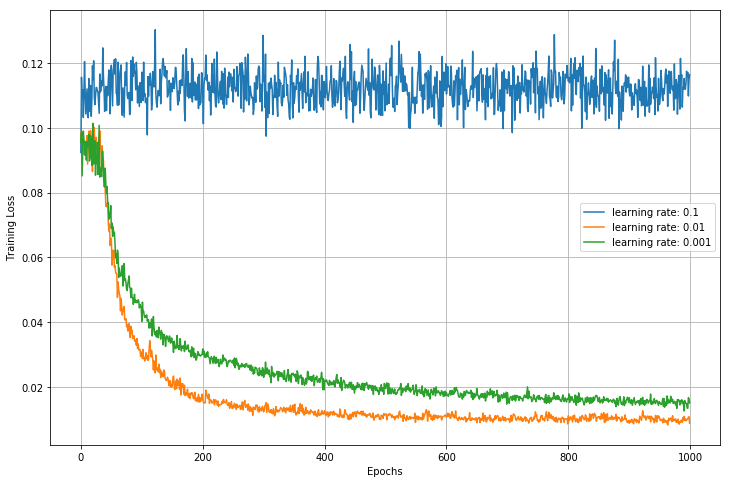

In [48]:
plt.figure(figsize=(12, 8))
for k, learning_rate in enumerate(learning_rates):
    plt.plot(train_losses[k,:], label="learning rate: {}".format(learning_rate))
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend(loc='best')